# Rede Neural para prever o preço de carros usados.

O objetivo deste tutorial é demonstrar para iniciantes em
Deep Learning como criar uma rede neural simples para prever
o preço de carros usados.

Esse exercício utiliza uma adaptação do dataset
[100,000 UK Used Car Data set](https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes).

Confira este [link](build_dataset/README.md)
para ver como o arquivo utilizado neste guia foi gerado.

Vamos usar *tensorflow*, *pandas* e *keras* para esta tarefa.
A próxima célula importa essas bibliotecas.

In [1]:
import pandas as pd
import tensorflow as tf

## Carregando o dataset

Vamos carregar os dados que iremos usar durante este tutorial de um
arquivo csv para um dataframe pandas

O arquivo onde está o nosso dataset é o `used_cars.csv`.
Ele contém dados de venda de veículos Volkswagen usados no Reino Unido.

In [2]:
raw_dataset = pd.read_csv('used_cars.csv')
raw_dataset

,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,2019,17000,Manual,8000,Diesel,145,57.7,1.6
1,2019,36000,Automatic,4000,Petrol,145,32.8,2.0
2,2015,19390,Automatic,20031,Petrol,200,40.4,2.0
3,2019,16290,Automatic,14821,Petrol,145,44.8,1.0
4,2017,16491,Automatic,20693,Petrol,20,60.1,1.4
...,...,...,...,...,...,...,...,...
4858,2015,11750,Manual,79000,Diesel,20,67.3,2.0
4859,2016,11950,Automatic,41725,Petrol,30,53.3,1.4
4860,2017,12950,Automatic,44837,Diesel,20,67.3,2.0
4861,2014,11299,Manual,25495,Petrol,30,53.3,1.4


O nosso dataset tem 4.863 linhas com 8 colunas.
No jargão de Deep Learning chamamos cada linha do dataset de
`exemplo` e cada coluna de `feature`.

Este dataset possui features como ano de fabricação (year),
transmissão (transmission), milhagem (mileage),
combustível (fuelType), imposto (tax),
milhas por galão (mpg) e tamanho do motor (engineSize).

O campo preço (price) é o que estamos querendo aprender e logo mais vamos
separá-lo em outro dataset conhecido como `labels`.

Você pode pesquisar mais sobre o termos de *machine learning* no link
[Some Key Machine Learning Definitions](https://medium.com/technology-nineleaps/some-key-machine-learning-definitions-b524eb6cb48)

Agora que os nossos **dados brutos** estão carregados em um
dataframe pandas, é sempre uma boa prática deixa-los
intactos e realizar uma cópia deles para outro objeto
onde vamos trabalhar as nossas transformações.

In [3]:
dataset = raw_dataset.copy()
dataset.head()

,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,2019,17000,Manual,8000,Diesel,145,57.7,1.6
1,2019,36000,Automatic,4000,Petrol,145,32.8,2.0
2,2015,19390,Automatic,20031,Petrol,200,40.4,2.0
3,2019,16290,Automatic,14821,Petrol,145,44.8,1.0
4,2017,16491,Automatic,20693,Petrol,20,60.1,1.4


## One-Hot-Encoding

Repare que as colunas `transmission` e `fuelType`
do dataset não contém números.
Elas contem `strings` que representam categorias.

Embora as redes neurais possam trabalhar com `strings`
isso dificulta o aprendizado. Por exemplo, o nosso modelo
pode inferir coisas malucas a partir de `strings`,
como, por exemplo, que carros com transmissão com a letra "M"
são mais baratos.

Para contornar esse problema vamos utilizar um método
chamado **one-hot-encoding** que consiste em transformar
as categorias em colunas binárias.

A função abaixo extrai a feature do dataset e a transforma em
colunas binárias. Dê uma olhada nessa
[referência](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)
e em como ficou o nosso dataset depois dessa transformação.

In [4]:
def one_hot_encode(ds, feature):
  column = ds.pop(feature)
  one_hot_encoded = pd.get_dummies(column, drop_first=True)
  dataframe = pd.merge(
      left=ds,
      right=one_hot_encoded,
      left_index=True,
      right_index=True
  )
  return dataframe

In [5]:
dataset = one_hot_encode(ds=dataset, feature='transmission')
dataset = one_hot_encode(ds=dataset, feature='fuelType')
dataset

,year,price,mileage,tax,mpg,engineSize,Manual,Semi-Auto,Hybrid,Other,Petrol
0,2019,17000,8000,145,57.7,1.6,1,0,0,0,0
1,2019,36000,4000,145,32.8,2.0,0,0,0,0,1
2,2015,19390,20031,200,40.4,2.0,0,0,0,0,1
3,2019,16290,14821,145,44.8,1.0,0,0,0,0,1
4,2017,16491,20693,20,60.1,1.4,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
4858,2015,11750,79000,20,67.3,2.0,1,0,0,0,0
4859,2016,11950,41725,30,53.3,1.4,0,0,0,0,1
4860,2017,12950,44837,20,67.3,2.0,0,0,0,0,0
4861,2014,11299,25495,30,53.3,1.4,1,0,0,0,1


## Criação dos datasets de treinamento e teste

Vamos separar os nossos dados em dois datasets distintos.

- O dataset de treinamento
- O dataset de teste

In [6]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [7]:
len(train_dataset.index), len(test_dataset.index)

(3890, 973)

In [8]:
# Retirando os labels
train_labels = train_dataset.pop('price')
test_labels = test_dataset.pop('price')

In [9]:
train_stats = train_dataset.describe().transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
year,3890.0,2017.137532,2.063745,2000.0,2016.0,2017.0,2019.0,2020.0
mileage,3890.0,24508.412596,21963.680580,1.0,7100.0,19194.0,35336.0,193000.0
tax,3890.0,100.799486,65.392211,0.0,30.0,145.0,145.0,570.0
mpg,3890.0,56.181388,17.715311,24.6,47.1,53.3,62.8,188.3
engineSize,3890.0,1.667763,0.306599,0.0,1.5,1.6,2.0,3.2
Manual,3890.0,0.605656,0.488772,0.0,0.0,1.0,1.0,1.0
Semi-Auto,3890.0,0.274293,0.446215,0.0,0.0,0.0,1.0,1.0
Hybrid,3890.0,0.017738,0.132014,0.0,0.0,0.0,0.0,1.0
Other,3890.0,0.005141,0.071528,0.0,0.0,0.0,0.0,1.0
Petrol,3890.0,0.553728,0.497169,0.0,0.0,1.0,1.0,1.0


## Reescalonamento dos dados

Uma rede neural náo *exige* que os dados
estejam normalizados para funcionar.
No entanto `features` com escalas muito diferentes
podem afetar o aprendizado da rede.

Por exemplo, neste dataset temos uma `feature`
chamada `engineSize` que varia entre 0 e 3,55 e
outra chamada `mileage` que varia de 1 a 193.000.
Essa diferença de tamanhos fará com que a feature
`mileage` tenha mais impacto no aprendizado da rede
do que a feature `engineSize`.

Para evitar esse problema podemos usar dois
métodos:

- Normalização
- Padronização

A **padronização** dos dados consiste em transformá-los
para que tenham a média zero e variem em mais ou menos um
desvio padrão.

$$ X_{pad} = \frac{X - \mu}{\sigma} $$

A **normalização** reescala os dados num intervalo que
varia de 0 a 1.

$$ X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}} $$

Mais informações sobre esse importante tópico
podem ser encontradas em
[How, When, and Why Should You Normalize / Standardize / Rescale Your Data?](https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff)

O trecho de código abaixo implementa a padronização.
O código da normalização está comentado. Eu sugiro que
você experimente com os dois métodos e observe os efeitos
sobre os resultados desta rede neural.

In [10]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
    # return (x - train_stats['min']) / (train_stats['max'] - train_stats['min'])

In [11]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Observe como os dados agora têm média próxima de zero e desvio padrão 1.

In [12]:
normed_train_data.describe()

,year,mileage,tax,mpg,engineSize,Manual,Semi-Auto,Hybrid,Other,Petrol
count,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03,3.890000e+03
mean,-1.899720e-14,2.739882e-17,3.470517e-17,4.794794e-16,-1.032022e-16,7.078029e-17,6.393058e-18,-3.287858e-17,-2.283235e-18,1.013756e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-8.304094e+00,-1.115815e+00,-1.541460e+00,-1.782717e+00,-5.439559e+00,-1.239136e+00,-6.147109e-01,-1.343632e-01,-7.187927e-02,-1.113761e+00
25%,-5.511980e-01,-7.926000e-01,-1.082690e+00,-5.126293e-01,-5.471756e-01,-1.239136e+00,-6.147109e-01,-1.343632e-01,-7.187927e-02,-1.113761e+00
50%,-6.664202e-02,-2.419637e-01,6.759293e-01,-1.626496e-01,-2.210167e-01,8.068062e-01,-6.147109e-01,-1.343632e-01,-7.187927e-02,8.976276e-01
75%,9.024699e-01,4.929769e-01,6.759293e-01,3.736097e-01,1.083619e+00,8.068062e-01,1.626363e+00,-1.343632e-01,-7.187927e-02,8.976276e-01
max,1.387026e+00,7.671373e+00,7.175174e+00,7.457877e+00,4.997526e+00,8.068062e-01,1.626363e+00,7.440603e+00,1.390864e+01,8.976276e-01


In [13]:
def build_model():
  model = tf.keras.Sequential([
                               tf.keras.layers.Dense(units=9,
                                                     activation='relu',
                                                     input_shape=[len(train_dataset.keys())]),
                               tf.keras.layers.Dense(units=1)
  ])

  model.compile(
      loss='mse',
      optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
      metrics=['mae', 'mse']
  )

  return model

In [14]:
model = build_model()

2021-11-08 19:37:33.219896: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 99        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10        
Total params: 109
Trainable params: 109
Non-trainable params: 0
_________________________________________________________________


In [16]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

2021-11-08 19:37:36.162143: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


array([[-1.810147  ],
       [-0.6479186 ],
       [-0.68383074],
       [-0.6855785 ],
       [-1.2438102 ],
       [-0.85801786],
       [-0.8565395 ],
       [-1.5911381 ],
       [-0.9872696 ],
       [-0.05247145]], dtype=float32)

In [17]:
history = model.fit(
    normed_train_data,
    train_labels,
    epochs=1000,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)],
    verbose=0
)

In [18]:
hist = pd.DataFrame(history.history)
hist['EPOCH'] = history.epoch
hist.tail(10)

,loss,mae,mse,val_loss,val_mae,val_mse,EPOCH
400,2964009.75,1270.746582,2964009.75,2940035.00,1251.369019,2940035.00,400
401,2962894.25,1272.487915,2962894.25,2944473.75,1251.404907,2944473.75,401
402,2959055.00,1270.161987,2959055.00,2958638.75,1252.933838,2958638.75,402
403,2960980.00,1265.889038,2960980.00,2941283.25,1251.136719,2941283.25,403
404,2960817.00,1270.668579,2960817.00,2943146.00,1250.970947,2943146.00,404
405,2960808.75,1270.780151,2960808.75,2949666.50,1251.574829,2949666.50,405
406,2958885.50,1269.310181,2958885.50,2954225.50,1252.317749,2954225.50,406
407,2961409.25,1268.531128,2961409.25,2949437.50,1252.715698,2949437.50,407
408,2959916.75,1270.561401,2959916.75,2947408.00,1251.556641,2947408.00,408
409,2959319.50,1269.358154,2959319.50,2946166.75,1251.448120,2946166.75,409


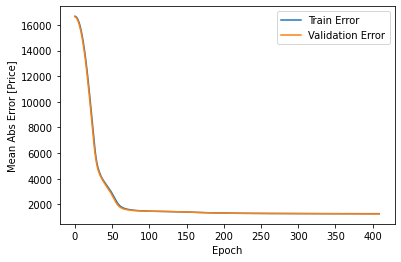

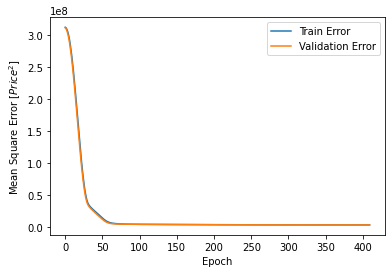

In [19]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['EPOCH'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Price]')
  plt.plot(hist['EPOCH'], hist['mae'], label='Train Error')
  plt.plot(hist['EPOCH'], hist['val_mae'], label='Validation Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Price^2$]')
  plt.plot(hist['EPOCH'], hist['mse'], label='Train Error')
  plt.plot(hist['EPOCH'], hist['val_mse'], label='Validation Error')
  plt.legend()

plot_history(history)

In [20]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

loss, mae, mse

(2602905.5, 1213.8448486328125, 2602905.5)

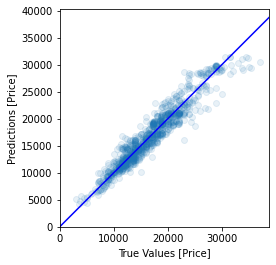

In [21]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions, alpha=0.1)
plt.xlabel('True Values [Price]')
plt.ylabel('Predictions [Price]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([0, 40_000], [0, 40_000], color='b')

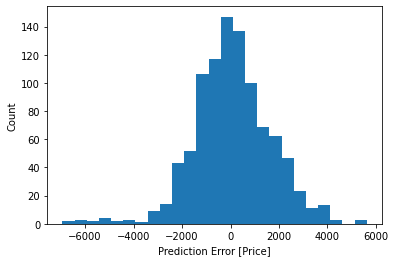

In [22]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Price]')
_ = plt.ylabel('Count')